In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import scipy

from allen_v1dd.client import EMClient
from allen_v1dd.em import DynamicSynapseGraph
from allen_v1dd.stimulus_analysis import analysis_tools as at
from allen_v1dd.stimulus_analysis.analysis_tools import iter_plane_groups

at.set_stylesheet()
%load_ext autoreload
%autoreload 2

# Load the EM client and synapse graph

In [2]:
em_client = EMClient()

/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/standard_transform/datasets.py:24: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, _ = R.align_vectors(np.array([[0, 1, 0]]), [up])


In [3]:
syn_graph_dir = "/Users/chase/Desktop"
syn_graph_filename = f"{em_client.cave_client.datastack_name}_v{em_client.version}_synapses.gpl"
syn_graph = DynamicSynapseGraph(em_client, debug=True, filename=os.path.join(syn_graph_dir, syn_graph_filename))

Loading graph from file /Users/chase/Desktop/v1dd_v347_synapses.gpl


# Setup stimulus analysis parameters

In [4]:
at.set_analysis_file("/Users/chase/Desktop/stimulus_analyses_v1.h5")

# We can also reduce the number of groups we iterate over by restricting mouse and column
at.set_included_mice([409828])
at.set_included_columns([1])
# at.set_included_volumes([1])

### Example to show all SSI metrics

63254


Text(0, 0.5, 'Cell count')

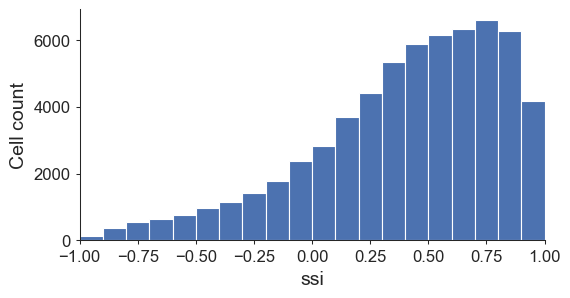

In [5]:
# Example to show the SSI metrics
ssi_metric = "ssi"
roi_to_ssi = {}

at.set_analysis_file("/Users/chase/Desktop/stimulus_analyses_v1.h5")
for group in iter_plane_groups():
    dgw_responsive = group["drifting_gratings_windowed"]["frac_responsive_trials"][()] >= 0.5
    dgf_responsive = group["drifting_gratings_full"]["frac_responsive_trials"][()] >= 0.5
    is_ignored_duplicate = group["is_ignored_duplicate"][()]
    # roi_inclusion_mask = dgw_responsive# & ~is_ignored_duplicate
    roi_inclusion_mask = dgw_responsive | dgf_responsive
    roi_prefix = f"{group.attrs['session_id']}_{group.attrs['plane']}" # e.g., M409828_13_1_456
    roi_ssi_values = group["ssi"][ssi_metric]

    for roi in np.where(roi_inclusion_mask)[0]:
        roi_id = f"{roi_prefix}_{roi}"
        roi_to_ssi[roi_id] = roi_ssi_values[roi]

print(len(roi_to_ssi))
plt.figure(figsize=(6, 3))
plt.hist(roi_to_ssi.values(), bins=np.arange(-1, 1.1, 0.1))
plt.xlim(-1, 1)
plt.xlabel(ssi_metric)
plt.ylabel("Cell count")

# Load EM mappings

### Root ID --> Cell type

In [6]:
cell_type_df = em_client.get_cell_type_table()
root_id_to_cell_type = pd.Series(index=cell_type_df.pt_root_id.values, data=cell_type_df.cell_type.values)
print(f"{len(root_id_to_cell_type)} cells have cell types")
cell_type_df.cell_type.value_counts()

3760 cells have cell types


PYC             3091
Non-neuronal     278
BC               146
Unsure I         102
MC                75
BPC               45
NGC               23
Name: cell_type, dtype: int64

### Root ID --> Soma position (microns)

In [7]:
soma_df = em_client.get_soma_positions(None)
root_id_to_soma_pos = pd.Series(index=soma_df.pt_root_id.values, data=soma_df.position_microns.values)
print(f"{len(root_id_to_soma_pos)} cells have soma positions")

# We only care about the cells that have been typed, so only including those
# root_id_to_soma_pos = pd.Series(index=)

155652 cells have soma positions


# Load the coregistered cells

In [8]:
coreg_df = em_client.get_coregistration_table(drop_duplicates=True)
print(f"{len(coreg_df)} coregistered cells")
print(f"{np.count_nonzero(coreg_df.dendrite_proof_complete)} coregistered cells with proofread dendrites")
# coreg_df = coreg_df[coreg_df.dendrite_proof_complete]
coreg_df.head()

163 coregistered cells
72 coregistered cells with proofread dendrites


,index,id,created,valid,target_id,session,scan_idx,unit_id,field,residual,...,ophys_volume,ophys_session_id,ophys_plane,ophys_roi,roi,position_microns,axon_proof_status,axon_proof_complete,dendrite_proof_status,dendrite_proof_complete
0,0,1,2023-04-14 22:08:40.446962+00:00,t,276266,1,3,117,1,NaN,...,3,M409828_13,1,117,M409828_13_1_117,"[778.7521791075498, 227.97907876189072, 29.657...",submitted,True,not_started,True
1,1,2,2023-04-14 22:08:40.447864+00:00,t,276140,1,3,75,1,NaN,...,3,M409828_13,1,75,M409828_13_1_75,"[816.1188928555765, 236.2662880987557, 17.5425...",submitted,True,submitted,True
2,2,3,2023-04-14 22:08:40.448713+00:00,t,290027,1,3,26,1,NaN,...,3,M409828_13,1,26,M409828_13_1_26,"[874.2243220704512, 248.26178219838565, -104.6...",not_started,False,not_started,False
3,3,4,2023-04-14 22:08:40.449580+00:00,t,365414,1,3,163,1,NaN,...,3,M409828_13,1,163,M409828_13_1_163,"[933.6856808451048, 252.00293174161231, -63.72...",not_started,False,not_started,False
4,4,5,2023-04-14 22:08:40.450423+00:00,t,365704,1,3,31,1,NaN,...,3,M409828_13,1,31,M409828_13_1_31,"[979.6986711301596, 251.2837669970616, -46.357...",not_started,False,not_started,False


In [9]:
root_id_to_roi = pd.Series(index=coreg_df.pt_root_id.values, data=coreg_df.roi.values)

# Build dataframe of EM/ophys metrics for coreg cells

In [10]:
df = []

for group in iter_plane_groups():
    sid = group.attrs["session_id"]
    plane = group.attrs["plane"]
    row_mask = (coreg_df.ophys_session_id == sid) & (coreg_df.ophys_plane == plane)

    if np.any(row_mask):
        for _, row in coreg_df[row_mask].iterrows():
            roi = row["ophys_roi"]

            # Add row to DF
            df.append(dict(
                session = sid,
                plane = plane,
                roi = roi,
                pt_root_id = row["pt_root_id"],
                dgw_frac_resp_trials = group["drifting_gratings_windowed"]["frac_responsive_trials"][roi],
                dgf_frac_resp_trials = group["drifting_gratings_full"]["frac_responsive_trials"][roi],
                ssi = group["ssi"]["ssi"][roi],
            ))

df = pd.DataFrame(df)
df.to_csv(f"/Users/chase/Desktop/coreg_ssi_values_v{em_client.version}-ophys-v1.csv", index=False)
df

,session,plane,roi,pt_root_id,dgw_frac_resp_trials,dgf_frac_resp_trials,ssi
0,M409828_13,1,117,864691132827688641,0.000000,0.125000,-0.009724
1,M409828_13,1,75,864691132728579766,0.000000,0.285714,0.762060
2,M409828_13,1,26,864691132727393198,0.625000,1.000000,-0.858749
3,M409828_13,1,163,864691132782526604,0.375000,0.285714,0.525628
4,M409828_13,1,31,864691132715818816,0.142857,0.125000,0.460345
...,...,...,...,...,...,...,...
158,M409828_13,6,0,864691132825574291,0.857143,0.500000,0.942505
159,M409828_13,6,92,864691132725005897,0.375000,0.375000,0.818785
160,M409828_13,6,2,864691132617552705,0.000000,0.375000,0.745811
161,M409828_13,6,155,864691132562133476,0.428571,0.125000,0.159799


# Identify the responsive ROIs

In [11]:
coreg_df_dgw_resp = coreg_df[coreg_df.roi.isin(roi_to_ssi.keys())]
coreg_df_dgw_resp

,index,id,created,valid,target_id,session,scan_idx,unit_id,field,residual,...,ophys_volume,ophys_session_id,ophys_plane,ophys_roi,roi,position_microns,axon_proof_status,axon_proof_complete,dendrite_proof_status,dendrite_proof_complete
2,2,3,2023-04-14 22:08:40.448713+00:00,t,290027,1,3,26,1,NaN,...,3,M409828_13,1,26,M409828_13_1_26,"[874.2243220704512, 248.26178219838565, -104.6...",not_started,False,not_started,False
8,8,9,2023-04-14 22:08:40.453717+00:00,t,365847,1,3,54,2,NaN,...,3,M409828_13,2,54,M409828_13_2_54,"[926.4697930445953, 267.9143746755472, -44.272...",not_started,False,not_started,False
10,10,11,2023-04-14 22:08:40.455317+00:00,t,276468,1,3,51,2,NaN,...,3,M409828_13,2,51,M409828_13_2_51,"[782.8845525042015, 247.530915922963, 34.58852...",not_started,False,not_started,False
11,11,12,2023-04-14 22:08:40.456161+00:00,t,276450,1,3,21,2,NaN,...,3,M409828_13,2,21,M409828_13_2_21,"[752.5111616865701, 241.30015753376037, 44.955...",submitted,True,not_started,True
12,12,13,2023-04-14 22:08:40.457160+00:00,t,276623,1,3,26,2,NaN,...,3,M409828_13,2,26,M409828_13_2_26,"[840.9597999446206, 253.46302660075477, 38.137...",submitted,True,submitted,True
13,13,14,2023-04-14 22:08:40.457959+00:00,t,364964,1,3,31,3,NaN,...,3,M409828_13,3,31,M409828_13_3_31,"[946.422706917656, 285.32553952184907, -91.404...",not_started,False,not_started,False
15,15,16,2023-04-14 22:08:40.459644+00:00,t,290087,1,3,89,3,NaN,...,3,M409828_13,3,89,M409828_13_3_89,"[743.946257307574, 266.6538340157297, -101.069...",not_started,False,not_started,False
17,17,18,2023-04-14 22:08:40.461849+00:00,t,277042,1,3,129,3,NaN,...,3,M409828_13,3,129,M409828_13_3_129,"[821.7073328364893, 267.68086079925865, 49.253...",not_started,False,not_started,False
24,24,25,2023-04-14 22:08:40.468216+00:00,t,291210,1,3,52,6,NaN,...,3,M409828_13,6,52,M409828_13_6_52,"[803.5678390217986, 318.2531001780936, -51.688...",not_started,False,not_started,False
25,25,26,2023-04-14 22:08:40.469088+00:00,t,291495,1,3,23,6,NaN,...,3,M409828_13,6,23,M409828_13_6_23,"[836.4051977551355, 320.65421821215324, -38.10...",not_started,False,not_started,False


# Plot the SSI of the coreg cells

Text(0.5, 1.0, 'SSI of DGW-responsive, EM-coregistered cells (n=56)')

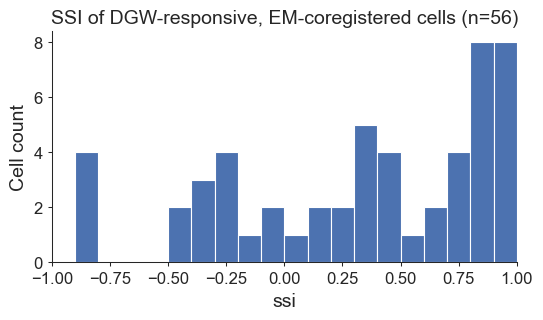

In [12]:
plt.figure(figsize=(6, 3))
plt.hist([roi_to_ssi[x] for x in coreg_df_dgw_resp.roi], bins=np.arange(-1, 1.1, 0.1))
plt.xlim(-1, 1)
plt.xlabel(ssi_metric)
plt.ylabel("Cell count")
plt.title(f"SSI of DGW-responsive, EM-coregistered cells (n={len(coreg_df_dgw_resp)})")

# Pre-load all the dendritic synapses

In [39]:
post_pt_root_ids = coreg_df_dgw_resp.pt_root_id.values
all_syn = syn_graph.get_dendritic_synapses(post_pt_root_ids)
all_syn

,pre_pt_root_id,post_pt_root_id,size,soma_soma_dist,soma_soma_dist_horiz,syn_pre_soma_dist_straight,syn_post_soma_dist_straight
0,864691132733308892,864691132727393198,2148,NaN,NaN,NaN,64.721920
1,864691132571693596,864691132727393198,477,280.558226,171.574784,323.163672,60.422500
2,864691132602960900,864691132727393198,117,NaN,NaN,NaN,82.972312
3,864691132634663326,864691132727393198,6970,NaN,NaN,NaN,65.210051
4,864691132603030481,864691132727393198,354,NaN,NaN,NaN,72.127836
...,...,...,...,...,...,...,...
167228,864691132635580455,864691132667436992,700,315.154997,297.877420,382.027420,93.329525
167229,864691132750986471,864691132667436992,1297,244.617470,125.173814,245.404327,28.335503
167230,864691132684442820,864691132667436992,4553,NaN,NaN,NaN,78.149627
167231,864691132825226387,864691132667436992,745,NaN,NaN,NaN,41.812588


In [40]:
print(f"{len(all_syn[~all_syn.soma_soma_dist.isna()].pre_pt_root_id.unique())} unique presynaptic cells with somas in volume")

4857 unique presynaptic cells with somas in volume


# Build DataFrame containing info on the inputs onto each cell

In [2]:
import napari

In [11]:
napari.Viewer?

Init signature:
napari.Viewer(
    *,
    title='napari',
    ndisplay=2,
    order=(),
    axis_labels=(),
    show=True,
) -> None
Docstring:     
Napari ndarray viewer.

Parameters
----------
title : string, optional
    The title of the viewer window. By default 'napari'.
ndisplay : {2, 3}, optional
    Number of displayed dimensions. By default 2.
order : tuple of int, optional
    Order in which dimensions are displayed where the last two or last
    three dimensions correspond to row x column or plane x row x column if
    ndisplay is 2 or 3. By default None
axis_labels : list of str, optional
    Dimension names. By default they are labeled with sequential numbers
show : bool, optional
    Whether to show the viewer after instantiation. By default True.
Init docstring:
Create a new model by parsing and validating input data from keyword arguments.

Raises ValidationError if the input data cannot be parsed to form a valid model.
File:           /opt/anaconda3/envs/allen_v1dd/lib

In [41]:
coreg_df.head()

,index,id,created,valid,target_id,session,scan_idx,unit_id,field,residual,...,ophys_volume,ophys_session_id,ophys_plane,ophys_roi,roi,position_microns,axon_proof_status,axon_proof_complete,dendrite_proof_status,dendrite_proof_complete
0,0,1,2023-04-14 22:08:40.446962+00:00,t,276266,1,3,117,1,NaN,...,3,M409828_13,1,117,M409828_13_1_117,"[778.7521791075498, 227.97907876189072, 29.657...",submitted,True,not_started,True
1,1,2,2023-04-14 22:08:40.447864+00:00,t,276140,1,3,75,1,NaN,...,3,M409828_13,1,75,M409828_13_1_75,"[816.1188928555765, 236.2662880987557, 17.5425...",submitted,True,submitted,True
2,2,3,2023-04-14 22:08:40.448713+00:00,t,290027,1,3,26,1,NaN,...,3,M409828_13,1,26,M409828_13_1_26,"[874.2243220704512, 248.26178219838565, -104.6...",not_started,False,not_started,False
3,3,4,2023-04-14 22:08:40.449580+00:00,t,365414,1,3,163,1,NaN,...,3,M409828_13,1,163,M409828_13_1_163,"[933.6856808451048, 252.00293174161231, -63.72...",not_started,False,not_started,False
4,4,5,2023-04-14 22:08:40.450423+00:00,t,365704,1,3,31,1,NaN,...,3,M409828_13,1,31,M409828_13_1_31,"[979.6986711301596, 251.2837669970616, -46.357...",not_started,False,not_started,False


In [42]:
unlabeled_str = "UNLBL"
out_of_vol_str = "OUTVOL"
near_far_threshold_horiz = 150

def get_cell_type_col(df, root_id_column):
    cell_type = pd.Series(index=df.index, data=unlabeled_str)
    in_vol = ~df["soma_soma_dist"].isna()

    cell_type[~in_vol] = out_of_vol_str
    cell_type[in_vol] = df[root_id_column].apply(lambda root_id: root_id_to_cell_type.get(root_id, unlabeled_str))
    cell_type[cell_type == "Unsure I"] = unlabeled_str # Unsure I --> Unlabeled

    return cell_type

df = []
df_col_ophys_start = 4
df_col_em_start = -1

for group in iter_plane_groups():
    sid = group.attrs["session_id"]
    plane = group.attrs["plane"]
    row_mask = (coreg_df_dgw_resp.ophys_session_id == sid) & (coreg_df_dgw_resp.ophys_plane == plane)

    if np.any(row_mask):
        for coreg_row in coreg_df_dgw_resp[row_mask].itertuples():
            pt_root_id = coreg_row.pt_root_id
            roi = coreg_row.ophys_roi
            pre_syn = syn_graph.get_dendritic_synapses(pt_root_id)

            if len(pre_syn) == 0:
                print(f"[WARN] Ignoring {pt_root_id} due to 0 dendritic synapses")
                continue

            pre_syn["pre_cell_type"] = get_cell_type_col(pre_syn, root_id_column="pre_pt_root_id")
            
            df_row = dict(
                pt_root_id = pt_root_id,
                session_id = coreg_row.ophys_session_id,
                plane = coreg_row.ophys_plane,
                roi = coreg_row.ophys_roi,

                # OPhys statistics
                dgw_frac_resp_trials = group["drifting_gratings_windowed"]["frac_responsive_trials"][roi],
                dgw_osi = group["drifting_gratings_windowed"]["osi"][roi],
                dgw_dsi = group["drifting_gratings_windowed"]["dsi"][roi],
                dgw_lifetime_sparseness = group["drifting_gratings_windowed"]["dsi"][roi],
                dgf_frac_resp_trials = group["drifting_gratings_full"]["frac_responsive_trials"][roi],
            )

            for dg, dg_group in (("dgw", group["drifting_gratings_windowed"]), ("dgf", group["drifting_gratings_full"])):
                df_row[f"{dg}_osi"] = dg_group["osi"][roi]
                df_row[f"{dg}_gosi"] = dg_group["gosi"][roi]
                df_row[f"{dg}_dsi"] = dg_group["dsi"][roi]
                df_row[f"{dg}_lifetime_sparseness"] = dg_group["lifetime_sparseness"][roi]

            for ssi in group["ssi"].keys():
                df_row[ssi] = group["ssi"][ssi][roi]


            df_row["run_corr"] = group["running_correlations"][roi]

            # Start EM metrics

            df_col_em_start = len(df_row)

            df_row["n_pre"] = len(pre_syn)
            
            for cell_type, count in pre_syn.pre_cell_type.value_counts().items():
                df_row[f"n_pre_{cell_type}"] = count
            for cell_type, count in pre_syn[pre_syn.soma_soma_dist_horiz <= near_far_threshold_horiz].pre_cell_type.value_counts().items():
                df_row[f"n_pre_near_{cell_type}"] = count
            for cell_type, count in pre_syn[pre_syn.soma_soma_dist_horiz > near_far_threshold_horiz].pre_cell_type.value_counts().items():
                df_row[f"n_pre_far_{cell_type}"] = count

            df.append(df_row)

df = pd.DataFrame(df)
df.fillna(0, inplace=True)
df = df.convert_dtypes()

# Add pre excitatory and inhib
df["n_pre_near"] = sum(df[c] for c in df.columns if "n_pre_near" in c)
df["n_pre_far"] = sum(df[c] for c in df.columns if "n_pre_far" in c)
df["n_pre_E"] = df["n_pre_PYC"]
df["n_pre_I"] = sum(df[f"n_pre_{t}"] for t in em_client.inh_cell_types)
df["n_pre_near_E"] = df["n_pre_near_PYC"]
df["n_pre_near_I"] = sum(df[f"n_pre_near_{t}"] for t in em_client.inh_cell_types)
df["n_pre_far_E"] = df["n_pre_far_PYC"]
df["n_pre_far_I"] = sum(df[f"n_pre_far_{t}"] for t in em_client.inh_cell_types)

df

[WARN] Ignoring 864691132669357329 due to 0 dendritic synapses


,pt_root_id,session_id,plane,roi,dgw_frac_resp_trials,dgw_osi,dgw_dsi,dgw_lifetime_sparseness,dgf_frac_resp_trials,dgw_gosi,...,n_pre_far_NGC,n_pre_far_BPC,n_pre_near,n_pre_far,n_pre_E,n_pre_I,n_pre_near_E,n_pre_near_I,n_pre_far_E,n_pre_far_I
0,864691132727393198,M409828_13,1,26,0.625,0.856131,0.616242,0.87956,1.0,0.536714,...,0,0,168,95,8,28,5,25,3,3
1,864691132826668720,M409828_13,1,329,0.5,0.698847,0.772591,0.770854,0.125,0.440558,...,1,0,435,470,34,203,12,78,22,125
2,864691132848681171,M409828_13,1,192,0.625,0.840054,0.772848,0.770088,0.375,0.559227,...,0,0,203,49,15,125,15,122,0,3
3,864691133070195401,M409828_13,1,176,0.5,0.638982,0.124223,0.737411,0.375,0.282433,...,0,0,289,71,35,165,34,164,1,1
4,864691132667436992,M409828_13,1,6,1.0,0.992243,0.948,0.895334,1.0,0.778965,...,0,1,238,111,20,137,17,103,3,34
5,864691132779220683,M409828_13,2,54,1.0,0.921443,0.329598,0.847093,0.285714,0.71697,...,0,0,103,37,4,24,4,22,0,2
6,864691132742394716,M409828_13,2,51,0.75,0.569413,0.925077,0.886293,0.285714,0.23736,...,0,0,186,83,21,104,21,78,0,26
7,864691133063965256,M409828_13,2,21,0.5,0.810903,0.871294,0.890637,0.142857,0.406006,...,0,0,181,88,11,110,8,86,3,24
8,864691132924264745,M409828_13,2,26,0.75,0.898459,0.604377,0.885107,0.428571,0.56735,...,0,0,309,85,23,214,23,213,0,1
9,864691132720617684,M409828_13,2,30,0.875,0.977155,0.929336,0.878253,0.714286,0.680579,...,0,0,228,67,19,117,19,115,0,2


Significance threshold: 0.0029411764705882353


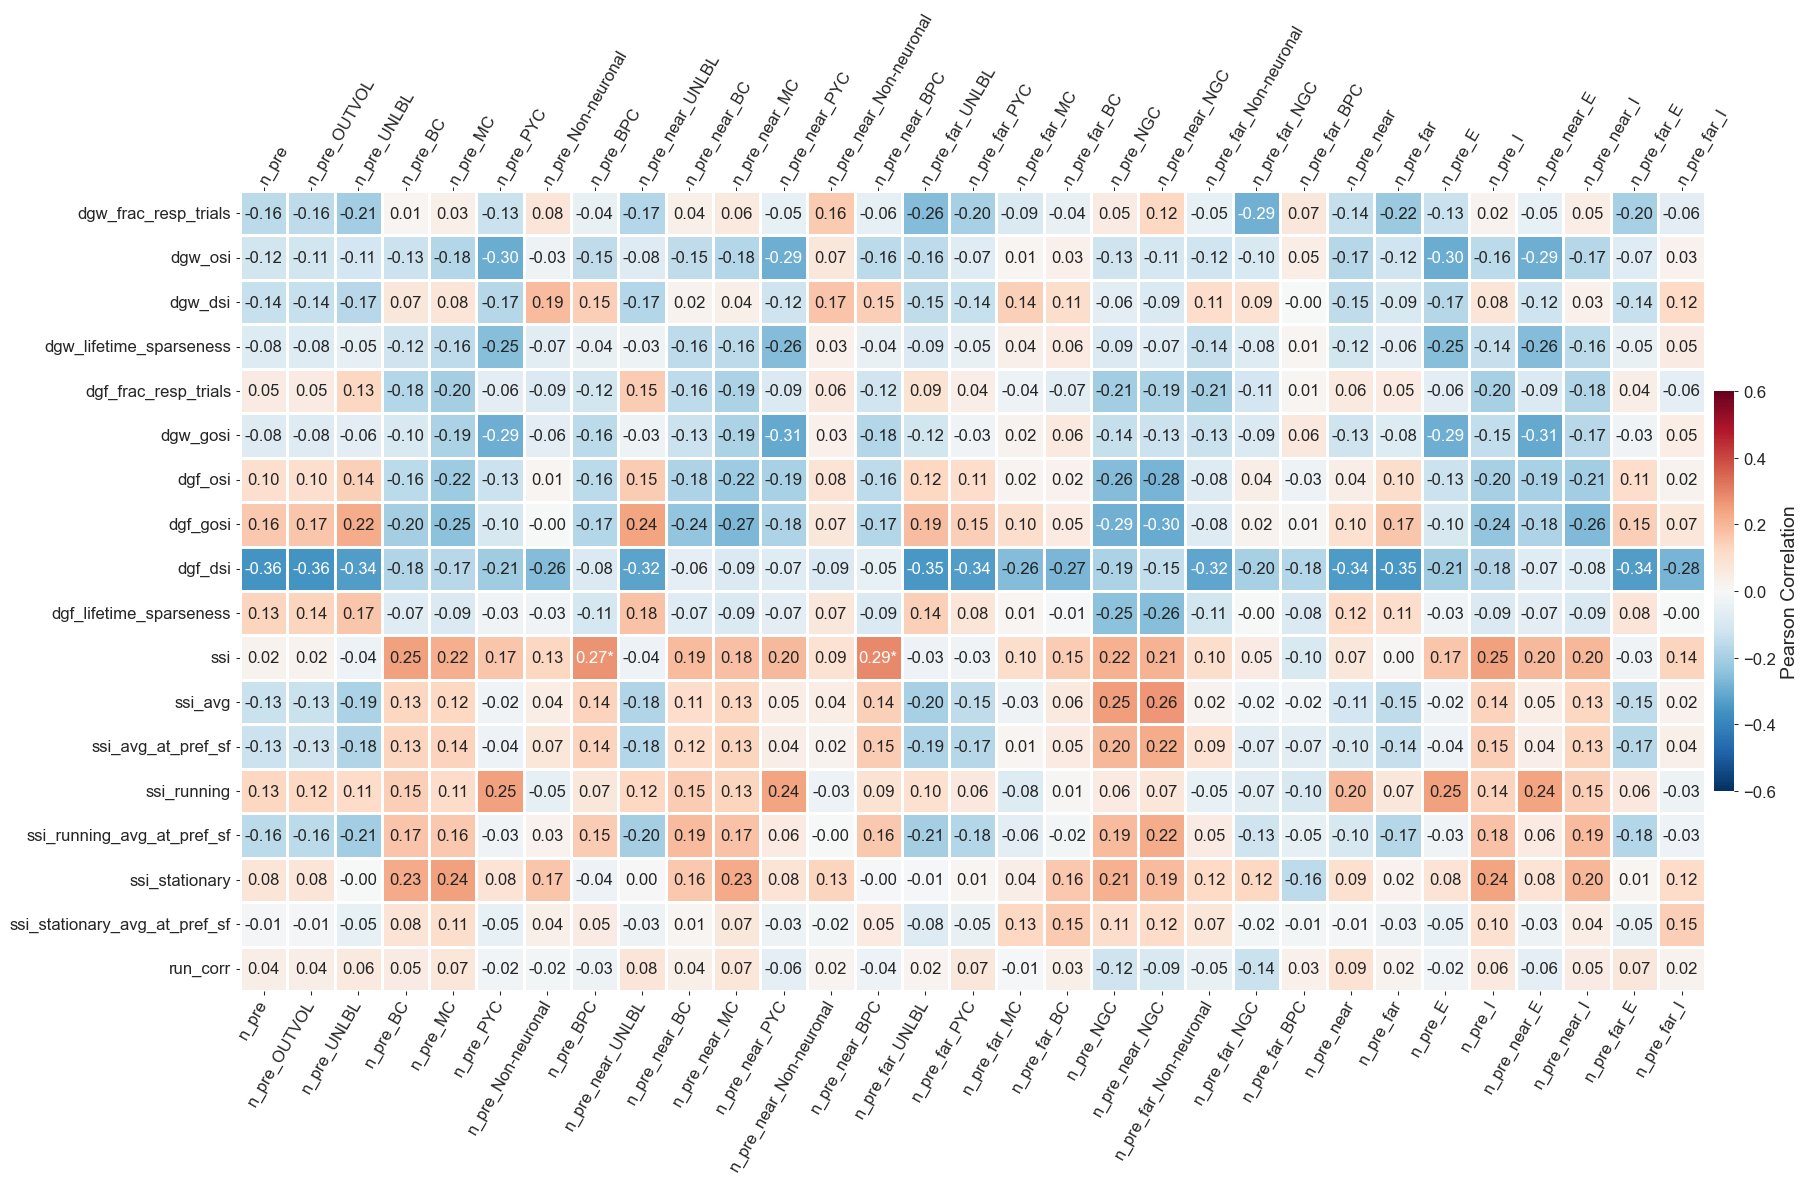

In [100]:
corr_df = df.corr()
corr_df = corr_df.loc[df.columns[df_col_ophys_start:df_col_em_start]][df.columns[df_col_em_start:]]
proba_df = corr_df.copy()

for row in corr_df.index:
    a = df[row].values
    for col in corr_df.columns:
        b = df[col].values
        test_result = scipy.stats.pearsonr(a, b)
        assert np.allclose(test_result.statistic, corr_df.at[row, col])
        # corr_df.at[row, col] = test_result.statistic
        proba_df.at[row, col] = test_result.pvalue

fig, ax = plt.subplots(figsize=(20, 12))

heatmap_data = corr_df.values
n_comparisons = len(corr_df.index) - 1
sig_thresh = 0.05 / n_comparisons
print(f"Significance threshold: {sig_thresh}")

annot = np.char.mod("%.2f", corr_df.values).astype(str)
annot[proba_df.values < 0.05] = np.char.add(annot[proba_df.values < 0.05], "*")

v = 0.6
sns.heatmap(
    heatmap_data,
    vmin=-v, vmax=v, cmap="RdBu_r",
    annot=annot, fmt='s',
    linewidths=1,
    cbar=True, cbar_kws=dict(shrink=0.5, pad=0.005, label="Pearson Correlation"),
    square=False,
    xticklabels=corr_df.columns,
    yticklabels=corr_df.index.values,
    ax=ax
)

ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=60, ha="right", va="center", rotation_mode="anchor")
plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=60, ha="left", va="center", rotation_mode="anchor")
fig.tight_layout()
fig.savefig(f"/Users/chase/Desktop/em-ophys-correlations-v{em_client.version}.png", bbox_inches="tight")

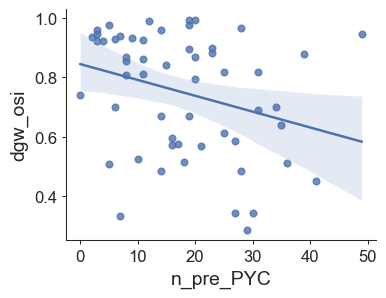

In [99]:
# Show scatter reg plot
fig, ax = plt.subplots(figsize=(4, 3))
# x, y = "n_pre_far_PYC", "dgf_dsi"
# x, y = "n_pre_MC", "ssi"
# x, y = "n_pre_near_PYC", "ssi"
# x, y = "n_pre_PYC", "dgf_osi"
# x, y = "n_pre", "dgf_dsi"
# x, y = "n_pre_near", "dgf_dsi"
x, y = "n_pre_PYC", "dgw_osi"
# x, y = "n_pre_MC", "ssi_stationary"

x = df[x].astype(float)
y = df[y].astype(float)

# mask = x < 10000
# x, y = x[mask], y[mask]

sns.regplot(x=x, y=y, ax=ax)
fig.savefig("/Users/chase/Desktop/corr_ex.png", dpi=150, bbox_inches="tight")

In [186]:
proba_df

,n_pre_OUTVOL,n_pre_UNLBL,n_pre_BC,n_pre_MC,n_pre_PYC,n_pre_Non-neuronal,n_pre_BPC,n_pre_near_UNLBL,n_pre_near_BC,n_pre_near_MC,...,n_pre_far_BPC,n_pre_far_NGC,n_pre_near,n_pre_far,n_pre_E,n_pre_I,n_pre_near_E,n_pre_near_I,n_pre_far_E,n_pre_far_I
dgw_frac_resp_trials,0.254928,0.125037,0.741824,0.734308,0.411011,0.552512,0.617049,0.224520,0.738235,0.655979,...,0.524688,0.004631,0.355823,0.083764,0.411011,0.750794,0.740619,0.698802,0.163462,0.746286
dgw_osi,0.402494,0.458764,0.269184,0.122540,0.015098,0.638477,0.117816,0.641804,0.186000,0.111896,...,0.611205,0.985075,0.190593,0.395168,0.015098,0.159946,0.014552,0.125564,0.738443,0.484887
dgw_dsi,0.301324,0.214708,0.685321,0.605834,0.204991,0.174615,0.295301,0.165843,0.808434,0.758468,...,0.746142,0.459744,0.252951,0.469763,0.204991,0.619361,0.464472,0.763772,0.116761,0.477988
dgw_lifetime_sparseness,0.541264,0.733666,0.308121,0.181897,0.040782,0.493090,0.516778,0.921397,0.177195,0.146790,...,0.752301,0.889426,0.360547,0.669740,0.040782,0.222287,0.031312,0.149715,0.959657,0.297377
dgf_frac_resp_trials,0.728561,0.321103,0.172719,0.097625,0.547606,0.423993,0.225133,0.156796,0.090192,0.067545,...,0.978409,0.921370,0.738546,0.633416,0.547606,0.111043,0.216350,0.066608,0.124976,0.244584
dgw_gosi,0.573687,0.682668,0.427215,0.107169,0.018551,0.481200,0.080628,0.890612,0.308757,0.104520,...,0.771600,0.567730,0.341370,0.555257,0.018551,0.199765,0.013569,0.162744,0.932796,0.527047
dgf_osi,0.444896,0.322770,0.359555,0.188302,0.506336,0.784890,0.402823,0.250297,0.271470,0.184785,...,0.344905,0.456584,0.707974,0.488507,0.506336,0.239359,0.240823,0.208915,0.232061,0.626538
dgf_gosi,0.227687,0.102661,0.181475,0.076692,0.486047,0.976114,0.151409,0.055031,0.086717,0.044747,...,0.558501,0.518791,0.472503,0.228203,0.486047,0.098845,0.152085,0.052495,0.075701,0.175520
dgf_dsi,0.007401,0.010182,0.260143,0.341491,0.194499,0.099937,0.930635,0.020648,0.475322,0.518549,...,0.185541,0.558640,0.013254,0.007531,0.194499,0.283717,0.535866,0.492608,0.051056,0.168422
dgf_lifetime_sparseness,0.322250,0.240091,0.764899,0.594585,0.957348,0.913717,0.434759,0.161859,0.616326,0.530464,...,0.183151,0.325248,0.347078,0.441890,0.957348,0.636647,0.618165,0.545467,0.254533,0.550908


  0%|          | 0/32 [00:00<?, ?it/s]

/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_29345/1230757954.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(5, 3))


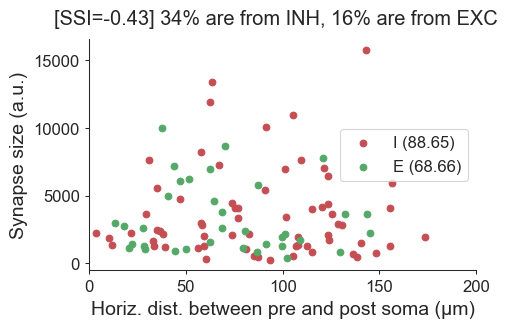

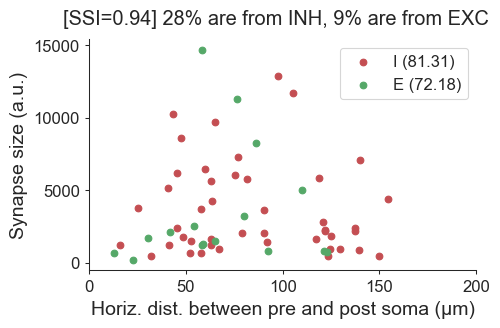

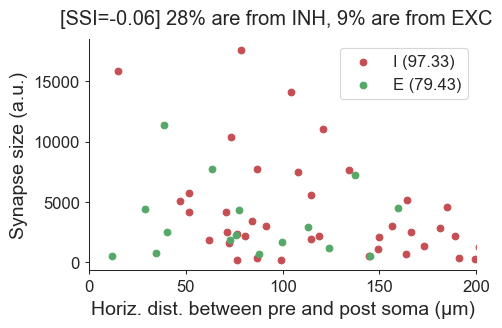

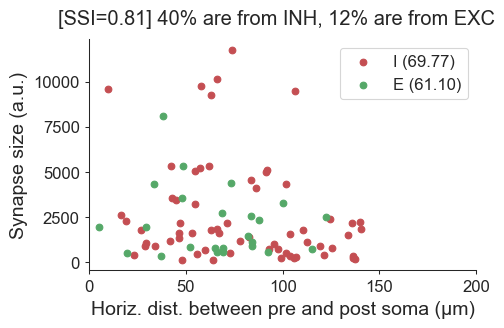

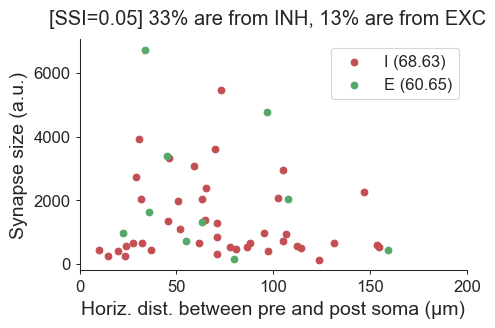

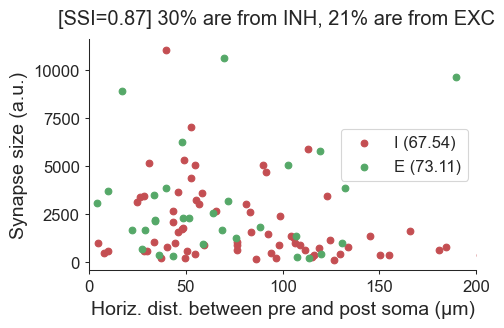

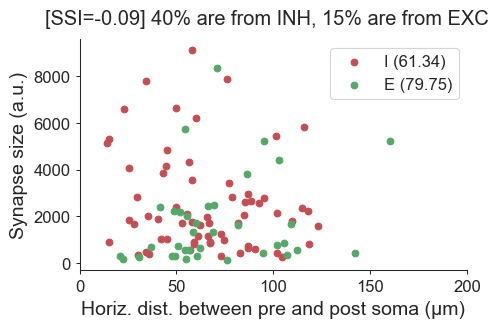

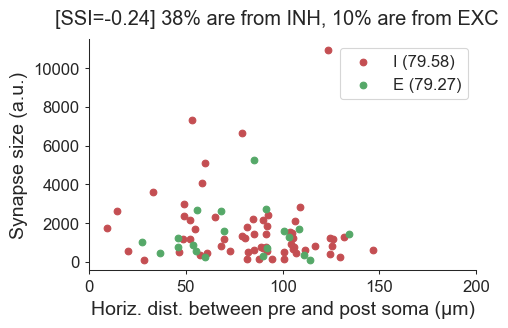

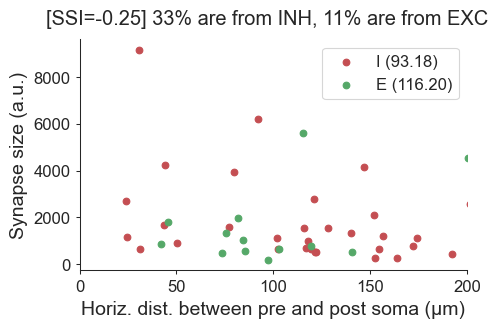

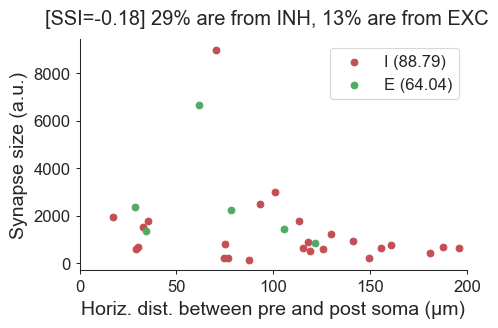

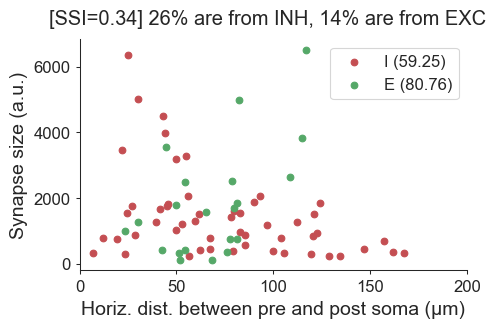

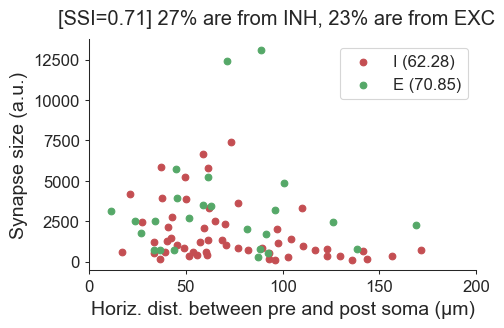

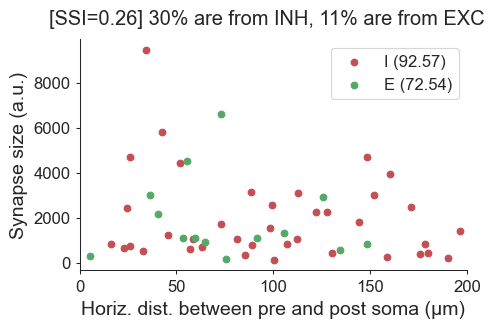

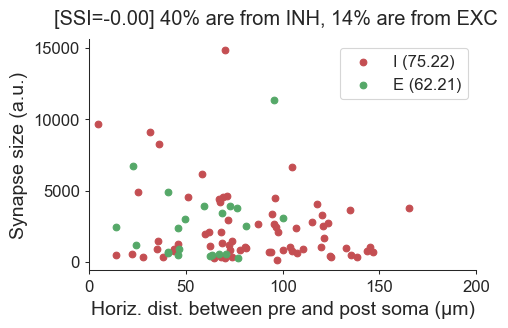

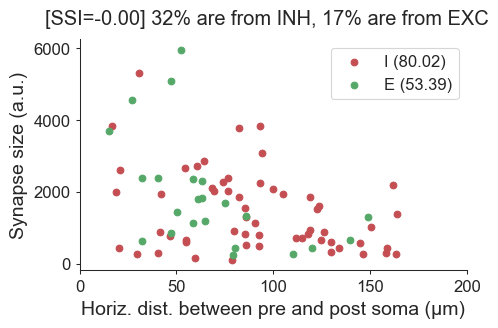

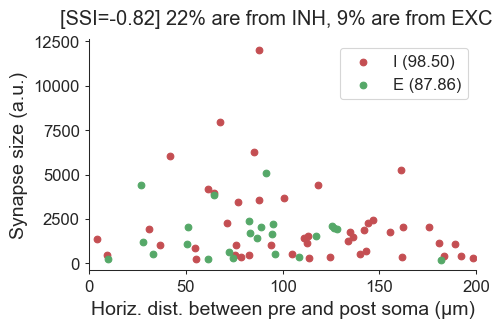

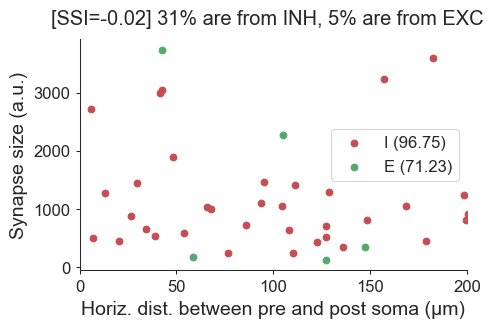

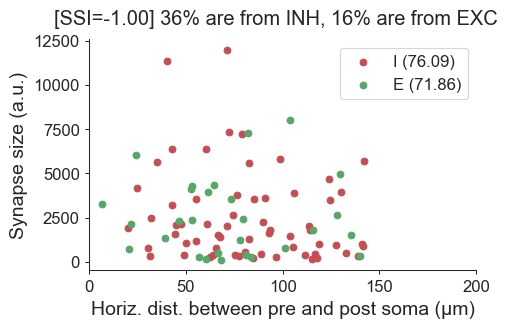

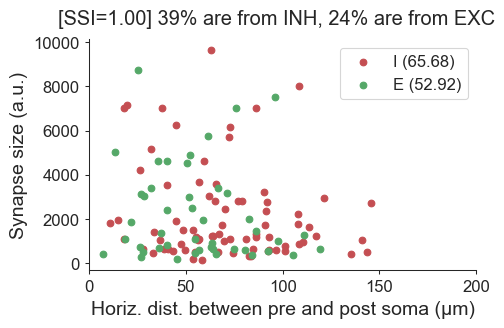

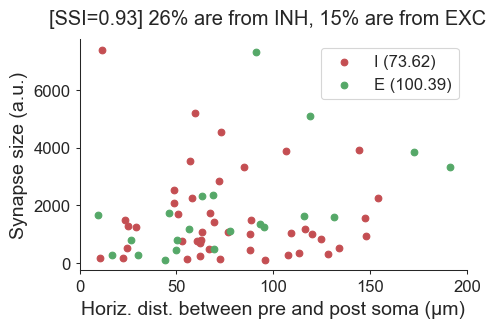

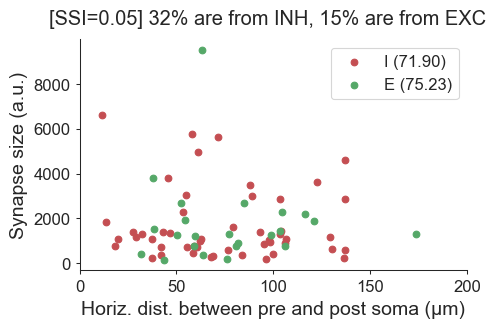

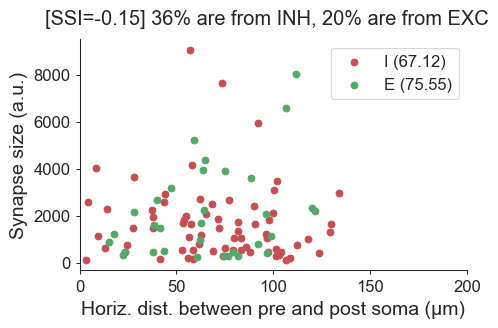

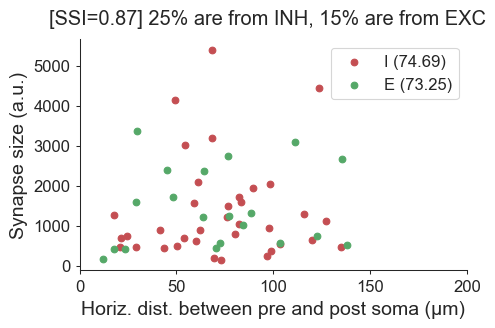

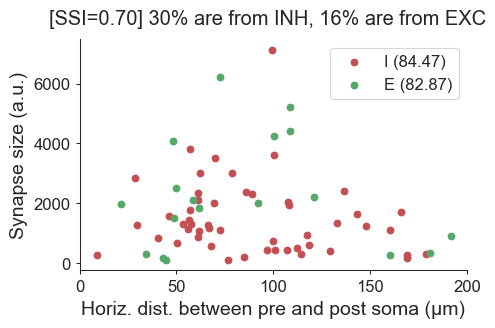

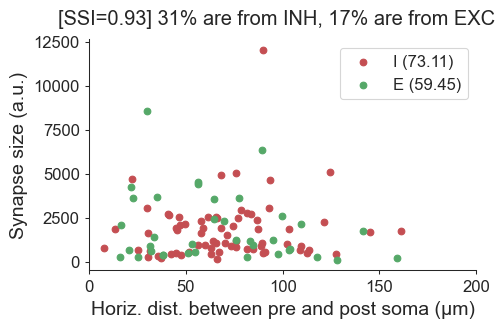

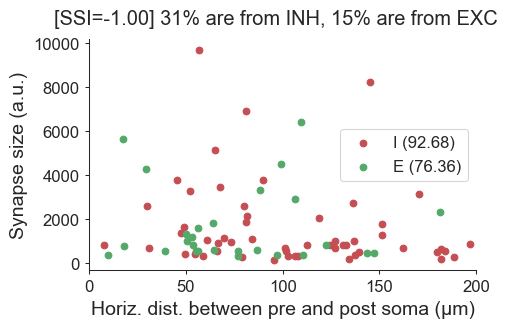

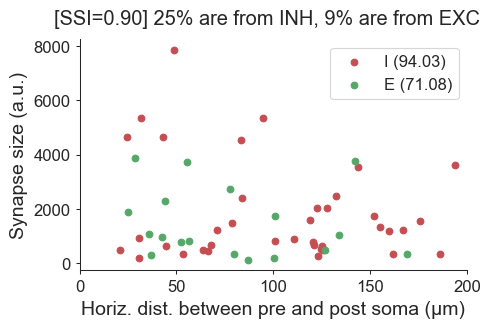

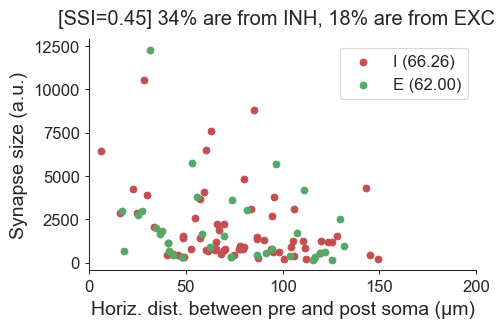

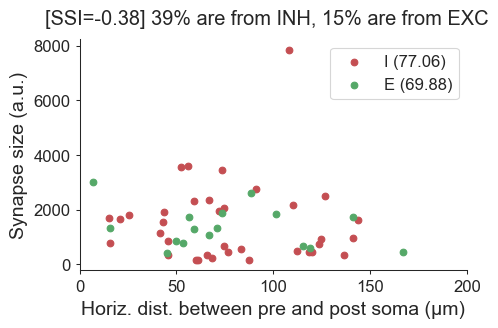

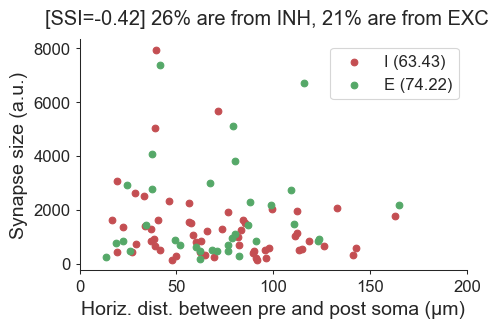

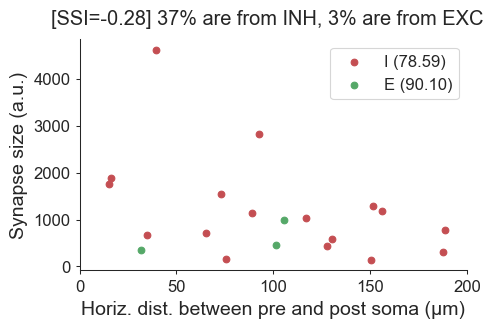

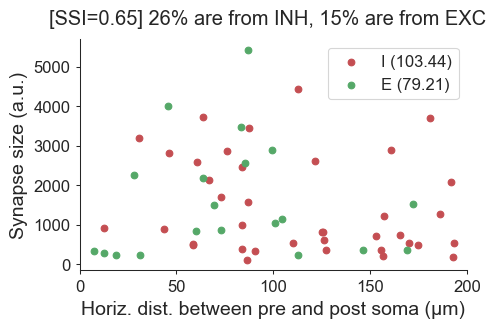

In [20]:
for post_id in tqdm(post_pt_root_ids):
    den_syn = syn_graph.get_dendritic_synapses(post_id).groupby(["pre_pt_root_id", "post_pt_root_id"]).aggregate(dict(
        size="sum",
        soma_soma_dist="first", # these are the same for every (pre, post) pair, so just keep the first
        soma_soma_dist_horiz="first"
    )).reset_index()
    den_syn = den_syn[np.isfinite(den_syn.soma_soma_dist)]
    den_syn_from_inh = den_syn[den_syn.pre_pt_root_id.apply(lambda pre: root_id_to_cell_type.get(pre) in em_client.inh_cell_types)]
    den_syn_from_exc = den_syn[den_syn.pre_pt_root_id.apply(lambda pre: root_id_to_cell_type.get(pre) in em_client.exc_cell_types)]

    wgtavg_inh = np.average(den_syn_from_inh.soma_soma_dist_horiz, weights=den_syn_from_inh["size"])
    wgtavg_exc = np.average(den_syn_from_exc.soma_soma_dist_horiz, weights=den_syn_from_exc["size"])
    label_inh = f"I ({wgtavg_inh:.2f})"
    label_exc = f"E ({wgtavg_exc:.2f})"

    # fig, axs = plt.subplots(figsize=(10, 3), ncols=2)
    # axs[0].scatter(x=den_syn_from_inh.soma_soma_dist_horiz, y=den_syn_from_inh["size"], color="r")
    # axs[1].scatter(x=den_syn_from_exc.soma_soma_dist_horiz, y=den_syn_from_exc["size"], color="g")
    # plt.setp(axs, xlim=(0, 200))

    fig, ax = plt.subplots(figsize=(5, 3))
    ax.scatter(x=den_syn_from_inh.soma_soma_dist_horiz, y=den_syn_from_inh["size"], color="r", label=label_inh)
    ax.scatter(x=den_syn_from_exc.soma_soma_dist_horiz, y=den_syn_from_exc["size"], color="g", label=label_exc)
    ax.set_xlim(0, 200)
    ax.legend()
    ax.set_xlabel("Horiz. dist. between pre and post soma (µm)")
    ax.set_ylabel("Synapse size (a.u.)")


    ssi = roi_to_ssi[root_id_to_roi[post_id]]
    fig.suptitle(f'[SSI={ssi:.2f}] {den_syn_from_inh["size"].sum()/den_syn["size"].sum()*100:.0f}% are from INH, {den_syn_from_exc["size"].sum()/den_syn["size"].sum()*100:.0f}% are from EXC')


    # Plot the presynaptic somas for inh
    # den_syn_from_inh
    # ax.set_xlabel("X")
    # ax.set_ylabel("Z")
    # ax.axis("equal")

    # break